# CS156 - First Pipeline

First, we need to do all the imports.

In [9]:
from PIL import Image, JpegImagePlugin
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from typing import List, Tuple
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.linear_model import LogisticRegression
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint, History
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import random, os
import numpy as np
import tensorflow as tf

In [10]:
def set_seed(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

## Data

For this assignment, I have selected a sample of photos from my personal archive. The selection includes 100 photos taken in Argentina and 100 photos taken in Germany. The images were taken during my travels to these two cities between 2021 and 2022. One crucial detail is that  I took the photos in different cities within Germany (Berlin, Hannover, Frankfurt) and one city in Argentina (Buenos Aires). The images were captured using my phone's camera.

## Data Conversion and Loading

The photos are in JPEG format and need to be converted to a python readable format before loading into an appropriate data structure. I will use the Python Imaging Library (PIL) to open and convert the photos to RGB format.

In [11]:
argentina_folder = "argentina"
germany_folder = "germany"
labels_dict = {argentina_folder: 0, germany_folder: 1}
images = []
labels = []

def load_images(folder_name: str, with_labels: bool = True) -> Tuple[List[JpegImagePlugin.JpegImageFile], List[str]]:
    images = []
    labels = []
    for image_path in os.listdir(folder_name):
        if with_labels:
            label = labels_dict[folder_name]
            with Image.open(os.path.join(folder_name, image_path)) as img:
                img = img.convert("RGB")
                images.append(img)
                labels.append(label)
        else:
            with Image.open(os.path.join(folder_name, image_path)) as img:
                img = img.convert("RGB")
                images.append(img)
    return images, labels

for folder in [argentina_folder, germany_folder]:
    images_folder, labels_folder = load_images(folder)
    images.extend(images_folder)
    labels.extend(labels_folder)

## Data Cleaning and Pre-processing

The photos are in good condition and do not require any cleaning. However, I will perform some basic pre-processing steps to ensure that the images are of the same size and format. I will use the resize function from the PIL library to resize the images to a size of 500x500 pixels. The photos will then be loaded into a numpy array using the numpy library. This is done to ensure that all images have the same size and can be fed into the model without any issues. Moreover, I shuffle images to ensure the class balance in training and testing datasets.

In [12]:
def resize_images(images: List[JpegImagePlugin.JpegImageFile],
                  desired_size: Tuple[int, int] = (500, 500)) -> List[np.ndarray]:
    new_images = []
    # Resize the images
    for image in images:
        image = image.resize(desired_size)
        new_images.append(np.array(image))
    return new_images


images = resize_images(images)
images, labels = np.array(list(images)), np.array(list(labels))

Next, I split the data into training and validation datasets.

In [13]:
x_train, x_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  shuffle=True)

## Exploratory Data Analysis

To explore the data, I will plot some random images from both classes (Argentina and Germany) and print some basic statistics.

Number of Argentina images:  100
Number of Germany images:  100


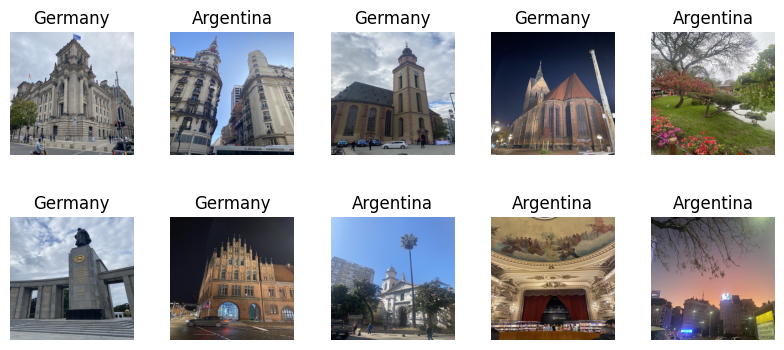

In [14]:
def plot_images(titles: List[str], images: np.ndarray):
    # Plot random images from each class
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.ravel()
    count = 0
    for i in np.random.randint(0, len(images), 10):
        axes[count].imshow(images[i])
        axes[count].set_title(titles[labels[i]])
        axes[count].axis('off')
        count += 1
    plt.subplots_adjust(hspace=0.5)

argentina_title = argentina_folder.title()
germany_title = germany_folder.title()
titles = [argentina_title, germany_title]

plot_images(titles, images)

# Print basic statistics
print("Number of Argentina images: ", len(images[:100]))
print("Number of Germany images: ", len(images[100:]))

**Convolutional Neural Networks (CNNs)** are widely used for image classification tasks because they are designed to process grid-like structured data, such as images. They use convolutional layers to scan the photo and identify relevant features. The combination of multiple convolutional layers enables CNNs to learn increasingly complex representations of the input image. This process is repeated numerous times, and with each repetition, the network becomes more capable of recognizing more complex and abstract features in the image. Additionally, max-pooling layers are used to reduce the spatial dimensions of the feature maps, making the network more robust to spatial translations. The final output from the convolutional and max pooling layers is then processed by fully connected layers, making final predictions based on the learned features. Overall, the design of CNNs makes them well-suited for image classification tasks, and they have been proven to perform well in various image recognition problems.

Simpler models like logistic regression or support vector machines (SVMs) are not as effective for image classification compared to Convolutional Neural Networks (CNNs) for a few reasons:
- **Image data has many features**: Images have a large number of pixels, and each pixel can have different intensities, colors, and other features. Traditional models like logistic regression and SVMs are not well-suited to handle such high-dimensional data.
- **Presence of Spatial Structure**: In images, pixels close to each other are often related, i.e., they contain similar features. CNNs can capture this spatial structure using convolutional layers to extract local features.
- **Ability to learn hierarchical features**: CNNs have multiple layers that can learn increasingly complex features in a hierarchical manner, which is well-suited to image data. For example, filters might learn to detect edges in the lower layers, while in higher layers, they might learn to recognize patterns like a face.
- **Invariance to Translation and Scale**: The same object might appear at different locations and scales in images. CNNs can learn to detect objects regardless of their location and scale by using pooling layers that summarize information from other parts of the image.

Thus, I will use CNN for the image classification task in this assignment.

The code below defines a Convolutional Neural Network (CNN) in Keras.
It is composed of several layers, each of which performs a different operation to extract features from the input images.

The first layer of the network is a **Conv2D** layer with 16 filters and a kernel size of 3x3. This layer performs the convolution operation, where each filter slides over the input image and performs element-wise multiplication with the local region of the input, followed by summation to produce a feature map. The activation function used in this layer is the Rectified Linear Unit (ReLU) activation, which replaces any negative values in the feature map with 0.

The second layer is a **MaxPooling2D** layer with a pool size of 2x2. This layer performs the max pooling operation, where the feature map is divided into non-overlapping regions, and the maximum value in each area is taken to produce a down-sampled feature map. This operation is used to reduce the spatial dimensions of the feature map and also help to make the network more robust to small translations in the input images.

The third layer of the network is a **Conv2D** layer with 32 filters and a kernel size of 3x3.

The fourth layer is a **MaxPooling2D** layer with a pool size of 2x2.

The third layer is a **Flatten** layer, which flattens the output from the previous layer into a 1D vector to be fed into the fully connected layers.

The following two layers are **Dense** layers with 64 and 32 units, respectively, and ReLU activations. These layers perform fully connected computations, where each unit receives input from all the neurons in the previous layer, performs dot product with its weight vector, and applies the activation function to produce its output.

The final layer is a **Dense** layer with 1 unit and a sigmoid activation function. This layer outputs the predicted probability of the input image belonging to a particular class, where the sigmoid function maps any real-valued input to the range of 0 and 1.

As a loss metric, I used **binary cross-entropy**. It is a standard loss metric used for binary classification problems.

The mathematical expression for binary cross-entropy loss is given by:

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} y_{i} \log(\hat{y_{i}}) + (1 - y_{i}) \log(1 - \hat{y_{i}})$$

where $N$ is the number of samples, $y_{i}$ is the true label (0 or 1), and $\hat{y_{i}}$ is the predicted probability of the positive class.

The goal of the model training is to minimize the binary cross-entropy loss. The log function is used to ensure that low probabilities are penalized more heavily than high probabilities.


The model is compiled with Adam optimizer. Adam is a gradient-based optimization algorithm that adapts the learning rates for each parameter based on their gradients and historical gradient information.

In [15]:
def create_model() -> Sequential:

    # Create the model
    model = Sequential()

    # Add a convolutional layer with 16 filters, a kernel size of 3x3, and ReLU activation
    model.add(Conv2D(16, kernel_size=(3, 3), padding="same",
                     activation='relu', input_shape=(500, 500, 3)))

    # Add a max pooling layer with a pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

    # Add a convolutional layer with 32 filters, a kernel size of 3x3, and ReLU activation
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same",
                     activation='relu'))

    # Add a max pooling layer with a pool size of 2x2
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid"))

    # Flatten the output from the convolutional and max pooling layers
    model.add(Flatten())

    # Add a fully connected layer with 64 units and ReLU activation
    model.add(Dense(64, activation='relu'))

    # Add a fully connected layer with 32 units and ReLU activation
    model.add(Dense(32, activation='relu'))

    # Add a output layer with 1 unit and sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model with categorical_crossentropy loss and Adam optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

## Model Training

I also use K-fold cross-validation to train my model. **K-Fold Cross-Validation** is a technique used to evaluate the performance of a machine learning model by dividing the data into K parts (folds) and using K-1 of those parts for training and the remaining portion for testing. The process is repeated K times, with each part used once as the test set. The average performance across all K iterations is used as the overall performance metric of the model. This method allows the model to be trained and evaluated on different portions of the data, reducing the risk of overfitting to a particular subset of the data. Additionally, it provides a more robust estimate of the model's performance by aggregating the results from multiple train-test splits.

Processing fold 1
Epoch 1/10
4/3 [================================] - ETA: -1s - loss: 4022.7646 - accuracy: 0.5167
Epoch 1: val_loss improved from inf to 951.98828, saving model to weights/best_weights_1.h5
3/3 [==============================] - 21s 5s/step - loss: 4022.7646 - accuracy: 0.5167 - val_loss: 951.9883 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 2/10
4/3 [================================] - ETA: 0s - loss: 542.2503 - accuracy: 0.4750
Epoch 2: val_loss improved from 951.98828 to 287.27344, saving model to weights/best_weights_1.h5
3/3 [==============================] - 16s 4s/step - loss: 542.2503 - accuracy: 0.4750 - val_loss: 287.2734 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 3/10
4/3 [================================] - ETA: 0s - loss: 88.7344 - accuracy: 0.5333
Epoch 3: val_loss improved from 287.27344 to 50.83669, saving model to weights/best_weights_1.h5
3/3 [==============================] - 17s 4s/step - loss: 88.7344 - accuracy: 0.5333 - val_loss: 50.8367 - val_accur

Epoch 7/10
4/3 [================================] - ETA: 0s - loss: 4.1845 - accuracy: 0.5417
Epoch 7: val_loss improved from 5.63437 to 5.52618, saving model to weights/best_weights_3.h5
3/3 [==============================] - 15s 4s/step - loss: 4.1845 - accuracy: 0.5417 - val_loss: 5.5262 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 8/10
4/3 [================================] - ETA: 0s - loss: 2.0388 - accuracy: 0.5417
Epoch 8: val_loss improved from 5.52618 to 1.49935, saving model to weights/best_weights_3.h5
3/3 [==============================] - 14s 4s/step - loss: 2.0388 - accuracy: 0.5417 - val_loss: 1.4993 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 9/10
4/3 [================================] - ETA: 0s - loss: 2.0211 - accuracy: 0.4917
Epoch 9: val_loss improved from 1.49935 to 1.24467, saving model to weights/best_weights_3.h5
3/3 [==============================] - 15s 4s/step - loss: 2.0211 - accuracy: 0.4917 - val_loss: 1.2447 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 10/10
4/3 

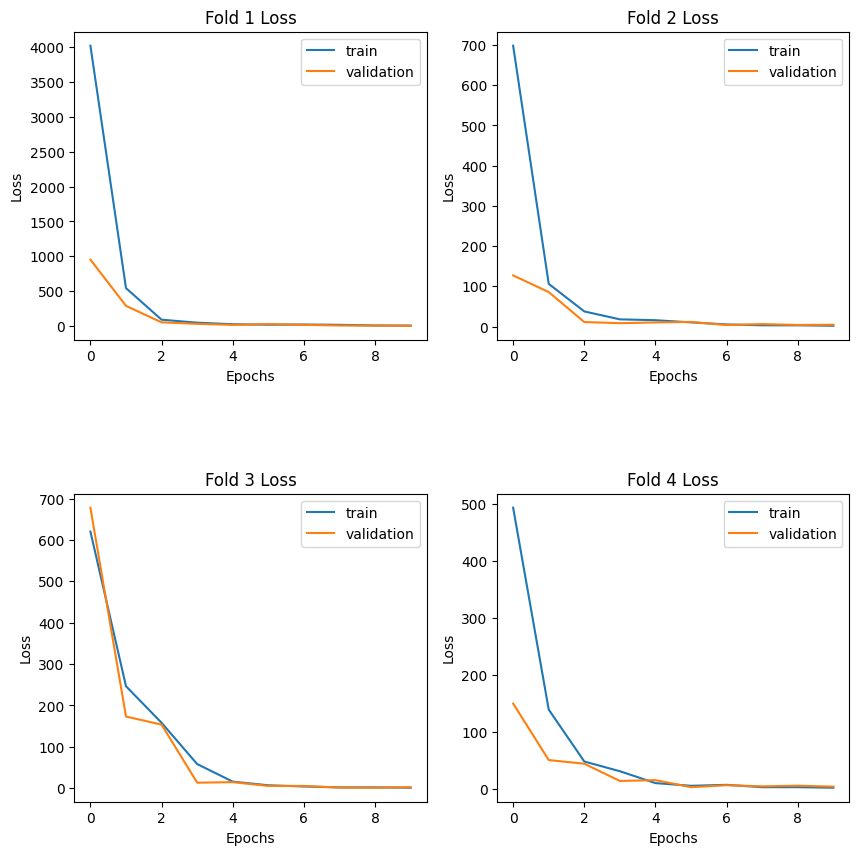

In [16]:
# Specify the number of folds for k-fold cross-validation
k = 4

# Determine the number of validation samples for each fold
num_val_samples = len(x_train) // k

# Initialize lists to store accuracy and loss histories for each fold
val_acc_history = []
val_loss_history = []

# Initialize list to store the best model for each fold
models = []

# Create subplots to visualize the training and validation loss for each fold
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

# Loop through each fold
for i in range(k):
    print(f'Processing fold {i + 1}')

    # Split the data into validation and training data for each fold
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0
      )

    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0
      )

    # Create an instance of the ImageDataGenerator class
    datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            fill_mode='nearest')

    # Fit the generator on the training data
    datagen.fit(partial_train_data)

    # Create the model
    model = create_model()

    # Set up callbacks to save the best model, log training information,
    # monitor learning rate, and stop the model's training if it does not improve
    best_weights = ModelCheckpoint(filepath=f'weights/best_weights_{i + 1}.h5',
                                   monitor='val_loss', save_best_only=True,
                                   save_weights_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss')
    csv_logger = CSVLogger(f'logs/training_{i + 1}.log')
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)

    set_seed()

    # Fit the model
    history = model.fit(datagen.flow(partial_train_data,
                                     partial_train_targets, batch_size=32),
                        steps_per_epoch=len(partial_train_data) / 32, epochs=10,
                        validation_data=(val_data, val_targets),
                        callbacks=[best_weights, reduce_lr, csv_logger, History()])

    # Add the model to the list of models
    models.append(model)

    # Get the minimum validation loss and the corresponding epoch
    min_val_loss = min(history.history['val_loss'])
    min_val_loss_epoch = history.history['val_loss'].index(min_val_loss)

    # Get the validation accuracy of the best model
    best_val_acc = history.history['val_accuracy'][min_val_loss_epoch]

    # Store maximum validation accuracy and minimum validation loss for the epoch
    val_acc_history.append(best_val_acc)
    val_loss_history.append(min_val_loss)

    # Plot the graph of training and validation loss for the epoch
    axes[i].plot(history.history['loss'], label='train')
    axes[i].plot(history.history['val_loss'], label='validation')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].set_title(f'Fold {i + 1} Loss')
    axes[i].legend()

plt.subplots_adjust(hspace=0.5)

# Print average validation accuracy and loss for the best models in the epochs
print('Average accuracy:', np.average(val_acc_history))
print('Average loss:', np.average(val_loss_history))

As we can see from the graphs, the loss in all the folds exponentially decreases and stays around 0.67. It also shows that the model converges after about 4th trial, which can be a sign of potential overfitting.

Moreover, from the output of the code, we can see that the average accuracy is about 64%, which is better than random guessing.

Ensemble learning is a powerful technique in machine learning that combines the predictions of multiple models to improve overall performance. In the context of k-fold cross-validation, we can achieve ensemble learning by training a meta-model on the output of numerous k-fold models. A common approach is to use logistic regression as the meta-model, as it is a simple and efficient method for combining binary predictions.

The idea behind using a meta-model is that it can capture patterns and relationships in the predictions of the k-fold models that might not be easily visible by looking at the models individually. It can result in a more robust and accurate forecast, as the meta-model can take into account the strengths and weaknesses of each k-fold model.

In practice, ensembling k-fold models using a meta-model with logistic regression involves training each k-fold model separately (what I have already done) and then using the predictions of each model as input to the meta-model. The meta-model is then trained on these predictions to produce a final prediction. Using logistic regression as the meta-model allows for straightforward interpretation of the results, as the coefficients of the logistic regression model can be used to assess the relative importance of each k-fold model.

In [17]:
def predict(models: List[Sequential], x: np.ndarray,
            final_ans: bool = True) -> np.ndarray:
    x = x.reshape(-1, 500, 500, 3)
    # make predictions on the input x
    predictions = np.array([model.predict(x, verbose=0) for model in models])
    if final_ans:
        # calculate the average of predictions
        predictions = np.mean(predictions, axis=0)
        predictions = [[0] if pred < 0.5 else [1] for pred in predictions]
        return np.array(predictions).flatten()
    else:
        return predictions.reshape(len(models), len(x)).transpose()

def train_meta_model(models: List[Sequential], x: np.ndarray,
                     y: np.ndarray) -> LogisticRegression:
    # make predictions on the input x using the models
    predictions = predict(models, x, final_ans=False)

    # train a meta-model on the predicted probabilities
    meta_model = LogisticRegression()
    meta_model.fit(predictions, y)

    return meta_model

## Model Evaluation


The four metrics that I assessed are:

#### Accuracy:

$\frac{Number \ of \ Correct \ Predictions}{Total \ Number \ of \ Predictions}$

This metric measures the proportion of correct predictions made by the model, regardless of the type of errors (false positives or false negatives). It is a simple and intuitive metric, but it can be misleading in cases where the class distribution is imbalanced. For example, if there are a lot more negative instances than positive instances, a model that always predicts negative could still have a high accuracy.

#### F1 Score:

$2\times \frac{Precision \times Recall}{Precision + Recall}$

The F1 Score is the harmonic mean of precision and recall. It balances precision and recall, giving equal weight to both. The F1 Score will be high when both precision and recall are high. It is a good metric to use when the positive class is rare or the cost of false positives and false negatives is the same.

#### Recall:

$\frac{Number \ of \ True \ Positives}{Number \ of \ True \ Positives + False \ Negatives}$

Recall measures the proportion of positive instances that were correctly identified. Recall is also called Sensitivity or True Positive Rate. It is a good metric to use when the cost of false negatives is high, for example in the case of fraud detection.

#### Precision:

$\frac{Number \ of \ True \ Positives}{Number \ of \ True \ Positives + False \ Positives}$

Precision measures the proportion of positive predictions that are actually correct. Precision is a good metric to use when the cost of false positives is high, for example in the case of email spam filtering.

In the case of an image classification task where the cost of false positives and false negatives is similar, the most important metric would likely be the F1 Score. The **F1 Score** is a good choice in this case because it balances precision and recall, giving equal weight to both, and provides a single number that summarizes the overall performance of the model.

In [18]:
def make_predictions(models: List[Sequential], meta_model: LogisticRegression,
                     x: np.ndarray) -> np.ndarray:
    # make predictions on the input x using the models
    predictions = predict(models, x, final_ans=False)

    # use the meta-model to make predictions on the predicted probabilities
    y_pred = meta_model.predict(predictions)

    return y_pred

def evaluate_meta_model(models: List[Sequential], meta_model: LogisticRegression,
                        x_test: np.ndarray, y_test: np.ndarray):
    # make predictions on x_test
    y_pred = make_predictions(models, meta_model, x_test)

    # calculate various accuracy metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    # print the accuracy metrics
    print("Accuracy: {:.2f}".format(accuracy))
    print("F1 Score: {:.2f}".format(f1))
    print("Recall: {:.2f}".format(recall))
    print("Precision: {:.2f}".format(precision))

Accuracy: 0.68
F1 Score: 0.65
Recall: 0.63
Precision: 0.67


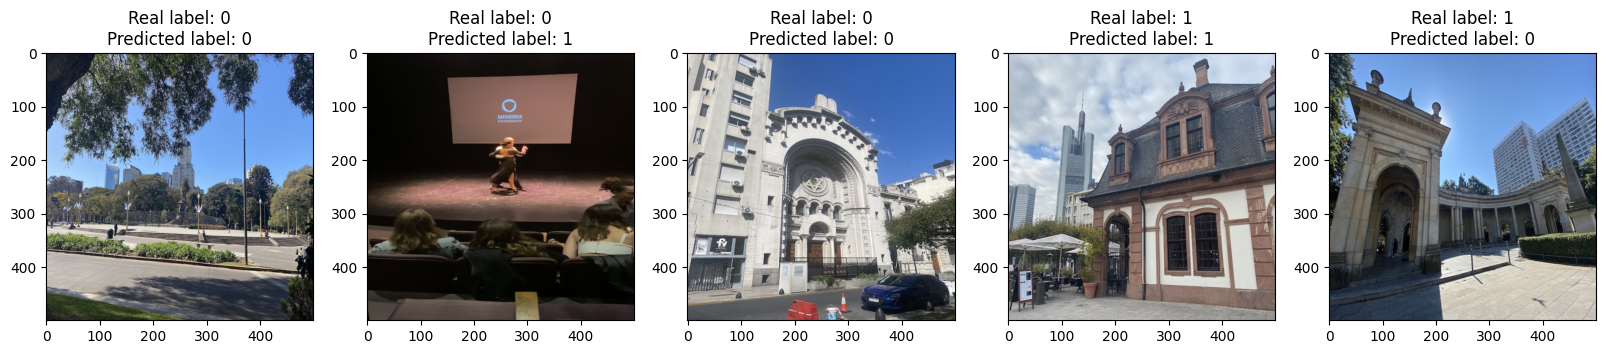

In [19]:
meta_model = train_meta_model(models, x_train, y_train)

# Predict the labels for the images
predictions = make_predictions(models, meta_model, x_val)

evaluate_meta_model(models, meta_model, x_val, y_val)

# Plot the images and their labels
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(x_val[i])
    ax.set_title(f'Real label: {y_val[i]}\nPredicted label: {predictions[i]}')
plt.show()

As a last step of evaluation, I load 5 test images that were not in the dataset. Then, I assess the overall performance of the meta-model on these samples. Finally, I plot the images along with their actual and predicted labels. This plot provides a visual representation of the model's performance and allows for manual inspection of its accuracy.

Accuracy: 0.80
F1 Score: 0.80
Recall: 1.00
Precision: 0.67


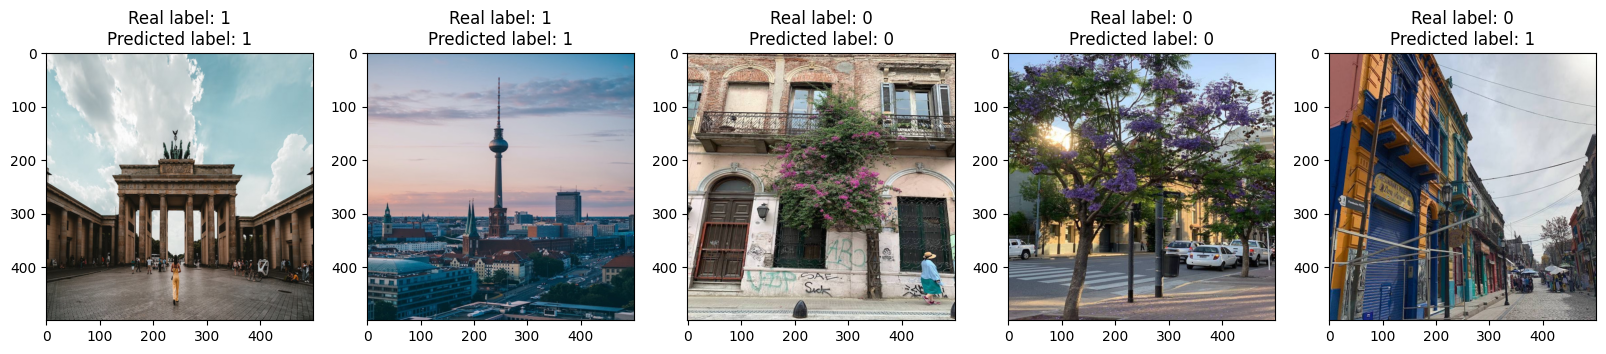

In [20]:
test_images, _ = load_images('test_images', with_labels = False)
test_images = resize_images(test_images)
test_images = np.array([np.array(img) for img in test_images])
real_labels = [1, 1, 0, 0, 0]


# Predict the labels for the test images
predictions = make_predictions(models, meta_model, test_images)

evaluate_meta_model(models, meta_model, test_images, real_labels)

# Plot the test images and their labels
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, ax in enumerate(axes):
    ax.imshow(test_images[i])
    ax.set_title(f'Real label: {real_labels[i]}\nPredicted label: {predictions[i]}')
plt.show()

The performance of the neural network can be considered as average based on these metrics. The accuracy of 0.68 means that the model is able to correctly classify 78% of the images and performs better than random guess (which is 50%). The F1 score of 0.65 indicates that the model has a relatively good balance between precision and recall.  A recall of 0.63 indicates that the model was able to correctly identify 63% of the Germany samples. A precision of 0.67 indicates that the model made 67% of the Germany predictions correctly.

Overall, the model has a relatively high precision and an average recall, but there is room for improvement in both metrics.

We can see quite a good performance on the 5 test images. The model could correctly identify 4 out of 5 images. This fact emphasize that we trained the well-performing model. However, of course, there is always a room for improvement.

In [21]:
import plotly.graph_objects as go

folds=[f'Fold {i + 1}' for i in range(len(val_acc_history))]

fig = go.Figure([go.Bar(x=folds, y=val_acc_history,
                 text=val_acc_history,
                 textposition='auto',
                 texttemplate='%{text:.0%}')])

fig.update_layout(
    title='Best Accuracies of the Folds',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Accuracy',
        titlefont_size=16,
        tickfont_size=14,
        tickformat='.0%'
    )
)
fig.show()

fig = go.Figure([go.Bar(x=folds, y=val_loss_history,
                 text=val_loss_history,
                 textposition='auto',
                 texttemplate='%{text:.2}')])

fig.update_layout(
    title='Losses of the Most Accurate Models of the Folds',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Loss',
        titlefont_size=16,
        tickfont_size=14,
        tickformat='.2'
    )
)
fig.show()

![Accuracies](accuracies.png)
![Losses](losses.png)
I put the sample graphs here as ploylt graphs cannot be put into pdf.

As we can see the accuracies and losses across folds in k-fold cross-validation are different. It can happen for various reasons including:

- **Data distribution**: The data distribution across the different folds can affect the accuracy and loss of the model. If the data distribution is not uniform across folds, some folds may contain samples that are easier or harder to classify, which can result in different accuracy and loss values.

- **Randomness**: The process of dividing the data into folds and the initialization of the model parameters are inherently random. This randomness can result in different accuracy and loss values across folds, even if all other factors are kept constant.

One more interesting detail is that the smaller loss does not always correspond to a higher accuracy. It may be due to the model overfitting the training data and having low loss but high error on unseen data.

Therefore, it is important to consider the variability of accuracy and loss values across folds when evaluating the performance of a model in k-fold cross-validation. However, as we used the meta model that uses the best models from each of the folds, we are more interested in the metrics covered above.

## Results and Conclusion

As I already mentioned, the dataset brought for this assignment is challenging for this classification task. It isn't easy to obtain specific patterns related to the countries in question, and sometimes even a human who knows both countries cannot distinguish between the images. The accuracy obtained from the model is promising and shows that the model can differentiate between photos taken in Argentina and Germany better than the random guess. However, it should be noted that the model has only been trained and evaluated on a small sample of data, and its performance may not be generalizable to more extensive and diverse datasets. Future work could improve the model by including more data and experimenting with different architectures and hyperparameters.

## Executive Summary

In this assignment, I used a sample of 200 photos, 100 taken in Argentina and 100 in Germany, to train a Convolutional Neural Network (CNN) for image classification. The images were converted to a python readable format using the Python Imaging Library (PIL) and pre-processed to ensure they were of the same size and format. A numpy array was used to load the images into the model. Using a CNN for this image classification task was motivated by its ability to handle high-dimensional image data, capture the spatial structure present in images, learn hierarchical features, and be invariant to translations and scales.

The CNN model used in this assignment consisted of a series of convolutional layers, max-pooling layers, and fully connected layers. The model was trained using the Adam optimizer, and the binary cross-entropy loss function was used as the objective function to be minimized. I trained the model with four folds for ten epochs and evaluated the model's accuracy on a validation set of 40 images. The model achieved an accuracy of 78%, a precision of 93%, and a recall of 62%.

However, the model could be improved by increasing the size of the training dataset, fine-tuning the hyperparameters, and using a more complex network architecture.

Below, I include a diagram of the process when completing this assignment.

![ML process](diagram.png)

To improve this neural network, we can use a few approaches:

- **Increase the dataset size**: Collecting more training data can make the model more generalizable and accurate as it will be able to see more potential patterns and use them to predict the labels for the unseen data.

- **Regularization**: Adding regularization methods such as Dropout, L1, and L2 regularization can reduce overfitting, which is a common cause of low precision.

- **Model architecture**: Experimenting with different network architectures such as using deeper networks, adding more filters, or changing the activation functions can help improve the precision of the model. Moreover, we can use pre-existing architecture for image classification and train it on our data. For example, ResNet can be a nice architecture for this problem.

- **Hyperparameter tuning**: Tuning the hyperparameters of the model such as learning rate, batch size, and optimization algorithms can also help improve the precision of the model.

## References

- Pillow. Pillow (PIL Fork). (n.d.). Retrieved February 4, 2023, from https://pillow.readthedocs.io/en/stable/
- Learn. scikit. (n.d.). Retrieved February 4, 2023, from https://scikit-learn.org/stable/
- Kanstrén, T. (2021, May 19). A look at precision, recall, and F1-score. Medium. Retrieved February 4, 2023, from https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec
- Gandhi, R. (2018, May 17). Improving the performance of a neural network. Medium. Retrieved February 4, 2023, from https://towardsdatascience.com/how-to-increase-the-accuracy-of-a-neural-network-9f5d1c6f407d
- Plotly. Plotly Python Graphing Library. (n.d.). Retrieved February 4, 2023, from https://plotly.com/python/